In [1]:
# did you remember to change the 'device' in general_framework.py ?
from control_framework import *
from tutorialQA_framework import *
from tutorial1_framework import *
from mem_canvas_use_framework import *

from temp_recorder import *

# add more here, or comment out

device = torch.device('cuda:1') # let's use the alligator GPU
#device = torch.device('cuda:0')
device

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


device(type='cuda', index=1)

In [2]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

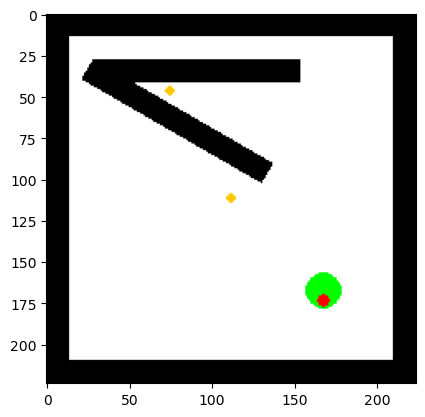

In [3]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [4]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [6]:
brain = EnhancedAgentBrain()
brain.move_to(device) # special function that wraps 'to'. Dumb? yes. Needed? Also yes.

#fname = 'brain_checkpoints/enhanced_brain_first_training_batch10000.pth'
#fname = 'brain_checkpoints/enhanced_brain_first_training_v2_batch160799.pth'
#fname = 'brain_checkpoints/enhanced_brain_control_training_v1_batch16600.pth'
#fname = 'brain_checkpoints/enhanced_brain_control_training_v2_batch55900.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v1_batch1199.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v2_batch24800.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v3_batch155466.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v4_batch399.pth'
#fname = 'brain_checkpoints/enhanced_brain_arrow_task_v5_batch133.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_v1_batch14250.pth'
#fname = 'brain_checkpoints/enhanced_brain_canvas_use_v2_batch29398.pth'
fname = 'brain_checkpoints/super_brain_transferred_weights.pth'
#fname = 'brain_checkpoints/super_brain_retraining_control_arrow_v1_batch33400.pth'

# A little extra code to avoid weird error
#brain.memory.remember(torch.randn(16, 1, 768).to(device))
#brain.memory.remember(torch.randn(8, 1, 768).to(device))

brain.load_state_dict(torch.load(fname, weights_only=True, map_location=device))
brain.reset()

In [7]:
gen_optimizer = optim.Adam(brain.parameters(), lr=0.00001, eps=1e-9)

In [8]:
# should possibly also include mem_enc? Should just be gen_optimizer? 
# ONLY use this in sessions where this is the only optimizer.
# General optimizer gets messed up if this is used
text_optimizer = optim.Adam(list(brain.text_enc.parameters()) + list(brain.text_dec.parameters()), lr=0.00001, eps=1e-9)

In [9]:
# useful to randomize the order in which the tasks are trained
class ReusableBuffer:
    def __init__(self, L, repetitions):
        self.L = []
        self.true_inds = []
        for i in range(len(L)):
            for j in range(repetitions[i]):
                self.L.append(L[i])
                self.true_inds.append(i)
        self.inds = list(range(len(self.L))) # could be longer or shorter than input L

    def draw(self, ind):
        return self.L[ind]

    def random_draw(self):
        ind_ind = random.randint(0, len(self.inds)-1)
        ind = self.inds[ind_ind]
        if ind_ind == (len(self.inds) - 1):
            self.inds = self.inds[:-1]
        else:
            self.inds = self.inds[:ind_ind] + self.inds[ind_ind + 1:]
        if len(self.inds) == 0:
            self.inds = list(range(len(self.L)))
        return self.L[ind], ind, self.true_inds[ind]

In [10]:
# for first task (and really anywhere I want to not reset between tasks)
# make sure the batch size matches
# add further functions in the firs list, and add their repetition number to the second list
#batch_size = 16
batch_size = 8
rb = ReusableBuffer([(arrow_task_batch, gen_optimizer, batch_size), \
                     (qa_task_batch, gen_optimizer, batch_size), \
                     (control_batch, gen_optimizer, batch_size), 
                     (mem_canvas_batch, gen_optimizer, batch_size)], \
                     #[0, 0, 0, 1])
                    [1, 0, 1, 0])

In [11]:
batches = [0, 0, 0, 0]

In [12]:
curr_mins = [1000.0, 1000.0, 1000.0, 1.0e6]

In [13]:
total_losses = [0, 0, 0, 0]

In [14]:
#torch.autograd.set_detect_anomaly(True)

In [15]:
import warnings
# I'll find the place that causes the 'non in-place resize later; for now, I don't want to clutter the results'
warnings.filterwarnings('ignore')

In [16]:
total_batches = 10000*100#6250*32

for b in range(total_batches):
    secs_to_cool = monitor_stage(device)
    if secs_to_cool > 0:
        print(f"Had to cool device for {secs_to_cool} seconds\n")
        
    triplet, _, ind = rb.random_draw()
    func, opt, batch_size = triplet
    
    batch_num = batches[ind]
    batches[ind] += 1

    #reset_model = True #default option; only transfer memory within the task files
    reset_model = (b % 3 == 2)

    printing = ((batch_num % 100) == 99)
    full_results = func(batch_size, brain, optimizer=opt, batch_num=batch_num, compute_grad=True, random_order=True, model_eval=False, reset_model=reset_model, printing=printing, training=True)
    L = full_results[0] # no need to look into the detailed loss report
    total_losses[ind] += L

    if printing: # if this is a significant batch
        avg_loss = total_losses[ind] / 100
        total_losses[ind] = 0
        print(f"Average total loss for task {ind}, last 100 batches: {avg_loss}\n\n\n\n")
        
        if avg_loss < curr_mins[ind]:
            curr_mins[ind] = avg_loss
            torch.save(brain.state_dict(), f"brain_checkpoints/super_brain_retraining_control_arrow_RESTART_v1_batch{b + 1}.pth")
            
    if b < 10:
        print(f"batch {b}, task {ind}, task batch_num {batch_num}\n")

batch 0, task 0, task batch_num 0

batch 1, task 2, task batch_num 0

batch 2, task 2, task batch_num 1

batch 3, task 0, task batch_num 1

batch 4, task 2, task batch_num 2

batch 5, task 0, task batch_num 2

batch 6, task 2, task batch_num 3

batch 7, task 0, task batch_num 3

batch 8, task 0, task batch_num 4

batch 9, task 2, task batch_num 4

Total recon loss: 0.0064416443929076195; that's 4.3228020668029785 text and 0.0021188424434512854 img


Average total loss for task 2, last 100 batches: 0.01102496888488531




Total loss: 0.007393233012408018; that's 0.0047905626706779 task and 0.0016958763590082526 recon and 4.533969402313232 total text


Average total loss for task 0, last 100 batches: 0.007623811955563724




Total loss: 0.007551493123173714; that's 0.00538284657523036 task and 0.00149982247967273 recon and 3.3441216945648193 total text


Average total loss for task 0, last 100 batches: 0.007457783278077841




Total recon loss: 0.00867375172674656; that's 3.0742425918579

KeyboardInterrupt: 

In [ ]:
# Updates: add sampling weights; add batch_num to print statement; split these two optimizers and optimize them separately

In [ ]:
#torch.cuda.empty_cache()